# Modelo de lenguaje con tokenización por caracteres

## Consigna
Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

## Sugerencias
Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU. rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [30]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

En este caso, voy a utilizar el Martin fierro de José Hernandez como corpus

In [2]:
raw_html = urllib.request.urlopen('https://www.textos.info/jose-hernandez/el-gaucho-martin-fierro/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [3]:
# en article text se encuentra el texto de todo el libro
len(article_text)

63273

Separo los caracteres del corpus en un set

In [4]:
chars_vocab = set(article_text)

In [5]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

56

In [6]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

## Tokenizar

In [7]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [10]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [11]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [12]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_val[0:10]

[[],
 [19],
 [18, 9],
 [21, 9, 31],
 [36, 23, 55, 26],
 [43, 13, 36, 3, 19],
 [35, 28, 44, 40, 19, 18],
 [9, 35, 43, 29, 55, 36, 43],
 [26, 9, 35, 43, 19, 43, 26, 19],
 [36, 35, 54, 9, 43, 40, 19, 26, 9]]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Comprobamos que tengan el mismo tamaño

In [22]:
print(X.shape, y.shape)

(56773, 100) (56773, 100)


Comprobamos que el target está corrido una posición respecto de X

In [26]:
print(X[0,:10])
print(f"   {y[0,:10]}")

[43 19 29 55 34 43 54 36 43 40]
   [19 29 55 34 43 54 36 43 40  9]


## Modelo

In [29]:
model = Sequential()
vocab_size = len(chars_vocab)

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

c:\Users\jonat\anaconda3\envs\ia_env\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 56)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 56)       │        11,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,656 (244.75 KB)

 Trainable params: 62,656 (244.75 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
class PplCallback(keras.callbacks.Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)
    
    
    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [34]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 2.8511
 mean perplexity: 9.66518497467041 

Saved new model!
222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 256ms/step - loss: 2.5323
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 2.1408
 mean perplexity: 8.976409912109375 

Saved new model!
222/222 ━━━━━━━━━━━━━━━━━━━━ 89s 403ms/step - loss: 2.1088
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 2.0410
 mean perplexity: 9.087752342224121 

222/222 ━━━━━━━━━━━━━━━━━━━━ 92s 413ms/step - loss: 2.0238
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 1.9743
 mean perplexity: 8.559306144714355 

Saved new model!
222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 389ms/step - loss: 1.9619
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 1.9206
 mean perplexity: 8.516324996948242 

Saved new model!
222/222 ━━━━━━━━━━━━━━━━━━━━ 93s 416ms/step - loss: 1.9065
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 1.8677
 mean perplexity: 8.26947212219238

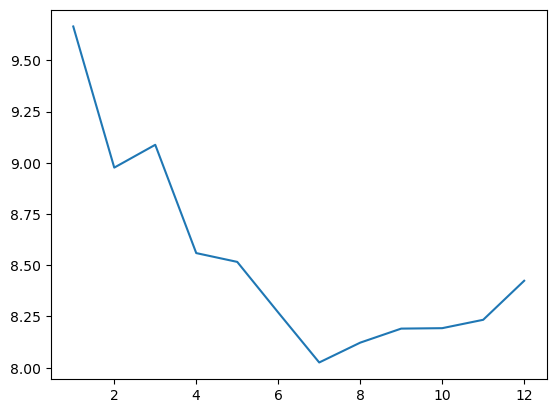

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [36]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

### Generación de secuencias

In [37]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [43]:
input_text='viento'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'viento\r\ny al viento el corozón\r\nla m'